In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import mplhep as hep
plt.style.use([hep.style.ROOT, hep.style.firamath])

In [18]:
#parse file and build a summary table
table=[]
with open('variations.txt') as fin:
    for l in fin.readlines():
        tokens=l.strip().split()
        if len(tokens)==1:
            cat=tokens[0]
        else:
            ibin=int(tokens[1])
            yields=float(tokens[-2])
            rel_var=float(tokens[-1])
            var_name=tokens[2]
            if var_name=='central':
                continue
            if var_name=='scenario':
                if '172.3' in tokens[3]: 
                    var_name='massDown'
                else: 
                    var_name='massUp'
            table.append( (cat,ibin,var_name,yields,rel_var) )

#convert the table to a pandas DataFrame
df=pd.DataFrame(table,columns=['cat','bin','variation','yields','rel_var'])
df.head()

,cat,bin,variation,yields,rel_var
0,eehighpt1b,1,muRUp,476.457095,-0.000013
1,eehighpt1b,1,PileUpDataMCJECUp,476.508706,0.000096
2,eehighpt1b,1,muFUp,476.591789,0.000270
3,eehighpt1b,1,fsrg2ggmuRUp,476.227271,-0.000495
4,eehighpt1b,1,PDFenvUp,476.206737,-0.000538


In [19]:
#assign a global binning based on (cat x bin)
all_cats = df['cat'].unique()
all_bins = df['bin'].unique()
all_global_bins=[(c,b) for c,b in itertools.product(all_cats,all_bins)]

def _globalBin(row):
    key=(row['cat'],row['bin'])
    return all_global_bins.index(key)+1

df['global_bin'] = df.apply(_globalBin,axis=1)
df.head()

,cat,bin,variation,yields,rel_var,global_bin
0,eehighpt1b,1,muRUp,476.457095,-0.000013,1
1,eehighpt1b,1,PileUpDataMCJECUp,476.508706,0.000096,1
2,eehighpt1b,1,muFUp,476.591789,0.000270,1
3,eehighpt1b,1,fsrg2ggmuRUp,476.227271,-0.000495,1
4,eehighpt1b,1,PDFenvUp,476.206737,-0.000538,1


In [37]:
#find best binning sort (lower to higher sensitivty to mass)
mass_mask=(df['variation']=='massUp')

abs_rel_var=np.abs( df[mass_mask]['rel_var'].values )
best_sort_for_mass = np.argsort(abs_rel_var)

global_bins=df[mass_mask]['global_bin'].values
sorted_global_bins=global_bins[best_sort_for_mass]
print('sorted global bins:',best_sort_for_mass)

sorted global bins: [26  2 15 12 39 53 65 45 46 47 74 22 25  8 24 17  9 32 50 10 51 81 67 31
 71 59 33 73 80 52 23 76  4 21 36 54 11  5 61 70 83 14 40 68 57 42  0 79
 58 75 16  1 60 38 30 77 18 20 43 66 19 82 72 44  3 56 64 49 35 55 78 37
  6 29 62 27 48 63 34 28 41  7 13 69]


In [73]:
#fill the ranked variations 
ranked_variations={}

syst_groups={
r'$\mu_R/mu_F$':['muRUp','muFUp','combMuRmuFUp'],
'PDF':['PDFenvUp'],
'FSR':['fsrg2ggmuRUp','fsrg2qqcNSUp','fsrg2qqmuRUp','fsrx2xgmuRUp', 'fsrq2qgmuRUp','fsrg2ggcNSUp'],
'hdamp':['hdampUp'],
'JES':['PileUpDataMCJECUp','AbsoluteScaleJECUp','AbsoluteMPFBiasJECUp','RelativeFSRJECUp','TimePtEtaJECUp','FlavorPureBottomJECUp','pileupUp','SinglePionECALJECUp', 'RelativeBalJECUp', 'FragmentationJECUp','RelativeJEREC1JECUp','slepbrUp','bfragUp'],
'JER':['JERSTmFEUp', 'JERstatUp','JERPUUp', 'JERJECUp','JERPLIUp','JERtruncUp', 'JERptCutUp','JERpTdepUp'],
'b-tag':['beffhfUp'],
'sel. eff':['eselUp','l1prefireUp','eetrigUp','mselUp', 'emtrigUp','mmtrigUp'],
'lepton scale':['eessystUp','eesscaletUp','messtatUp'],
'CR':['CRgmoveUp', 'CRerdUp','CRqcdUp'],
'UE':['UEUp'],
r'top-$p_T$':['topptUp'],
'mass':['massUp'],
}
       

for v in df['variation'].unique():
   
    #check which syst group should this variation belong to
    syst=None
    for s,v_list in syst_groups.items():
        if v in v_list:
            syst=s
    if syst is None: continue

    #fill the relative variations in ranked bins
    vals=[]
    for ibin in sorted_global_bins:
        mask=(df['variation']==v) & (df['global_bin']==ibin)
        try:
            vals.append( np.abs(df[mask]['rel_var'].values[0])  )
        except:
            #print('Warn: failed to find bin={} for v={}'.format(ibin,v))
            vals.append(0)
    vals=np.array(vals)
    
    #add in quadrature
    if not syst in ranked_variations:
        ranked_variations[syst]=np.zeros_like(vals)
    ranked_variations[syst] +=  vals**2
    
print('Filled ranked histograms for:',ranked_variations.keys())

Filled ranked histograms for: dict_keys(['$\\mu_R/mu_F$', 'JES', 'FSR', 'PDF', 'sel. eff', 'b-tag', 'lepton scale', 'hdamp', 'CR', 'JER', 'UE', 'top-$p_T$', 'mass'])


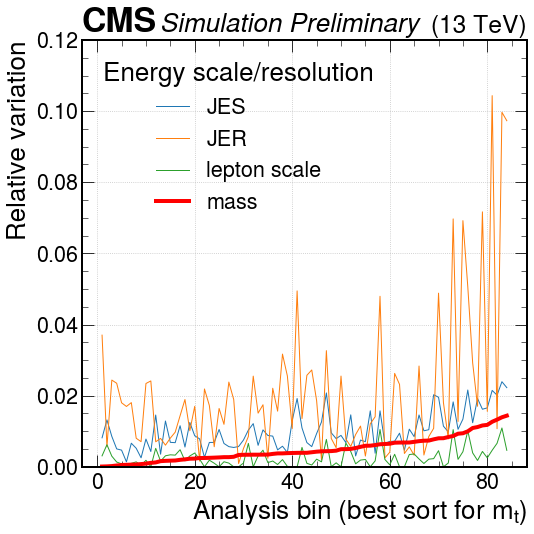

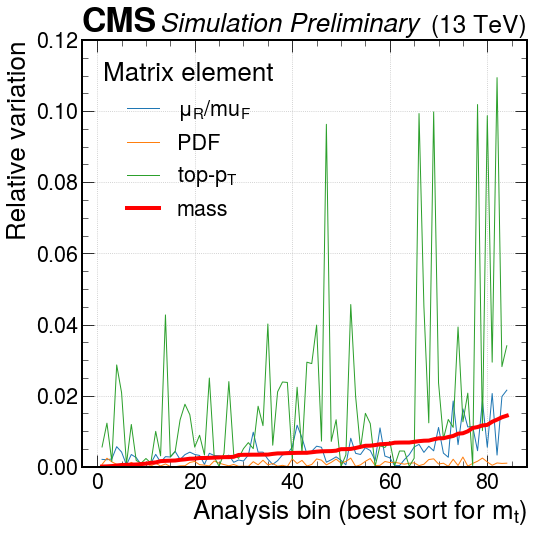

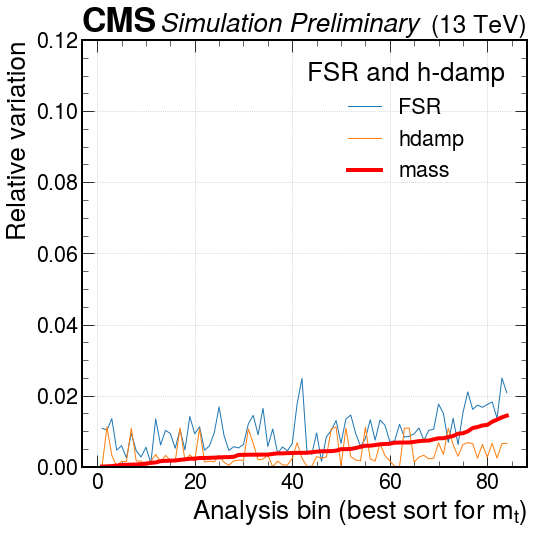

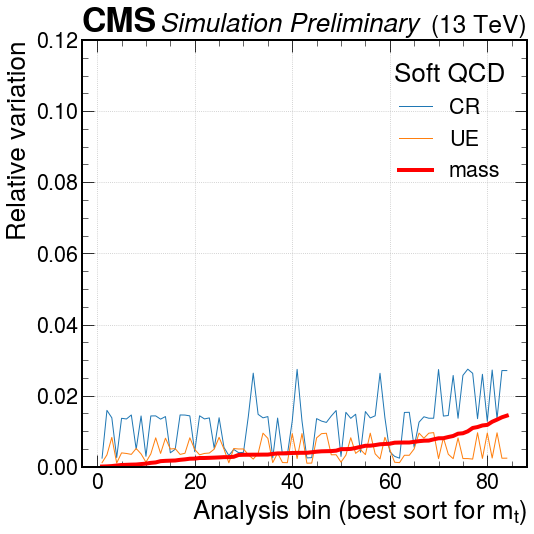

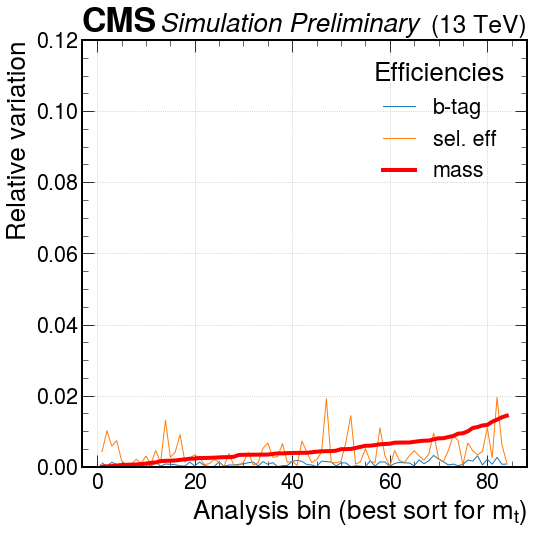

In [76]:
def showComparison(syst_list,title):
    fig,ax=plt.subplots(figsize=(8,8))

    xbins=sorted(list(df['global_bin'].unique()))
    for syst in syst_list+['mass']:
        histo=ranked_variations[syst]
        if syst=='mass':
            plt.plot(xbins,np.sqrt(histo),label=syst,color='red',linewidth=4)
        else:
            plt.plot(xbins,np.sqrt(histo),label=syst,linewidth=1)
        
    plt.ylabel('Relative variation')
    plt.xlabel(r'Analysis bin (best sort for $m_{t}$)')
    plt.ylim(0,0.12)
    plt.grid()
    plt.legend(title=title)
    hep.cms.label(loc=0)
    plt.tight_layout()
    plt.show()

showComparison(['JES','JER','lepton scale'],'Energy scale/resolution')
showComparison([r'$\mu_R/mu_F$','PDF',r'top-$p_T$'],'Matrix element')
showComparison(['FSR','hdamp'],'FSR and h-damp')
showComparison(['CR','UE'],'Soft QCD')
showComparison(['b-tag','sel. eff'],'Efficiencies')